# 外れ値除去 + スケーリング + 重回帰分析

1. データの読み込み
2. 外れ値除去 (1変数)
3. 外れ値除去 (全変数)
4. モデル構築
5. スケーリングを考慮した重回帰分析

## 1. データの読み込み

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [6]:
df = pd.read_csv("housing.csv")

In [7]:
df.head(3)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


## 2. 外れ値除去 (1変数)

3σ法 を利用 (正規分布に従っているデータにしか適用できない)

$$\mu - 3 \sigma \leq x \leq \mu + 3 \sigma$$

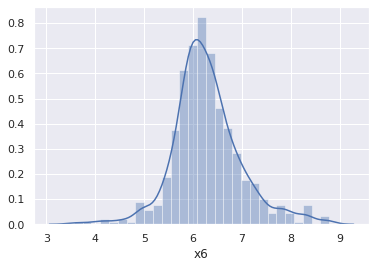

In [26]:
# x6は正規分布に従っていそう
sns.set()
sns.distplot(df["x6"])

In [13]:
col = "x6"

In [14]:
# 平均
mean = df.mean()
mean[col]

6.284634387351787

In [16]:
# 標準偏差
sigma = df.std()
sigma[col]

0.7026171434153237

### 3σ内に値が存在するレコードのみを抽出
$$\mu - 3 \sigma \leq x \leq \mu + 3 \sigma$$

In [19]:
# 下限値
low = mean[col] - 3 * sigma[col]
# 上限値
high = mean[col] + 3 * sigma[col]
print(f"low: {low}, high: {high}")

low: 4.176782957105816, high: 8.392485817597757


In [29]:
# レコードの抽出
df2 = df[(df[col] >= low) & (df[col] <= high)]
print(f"{len(df)}, {len(df2)}")

506, 498


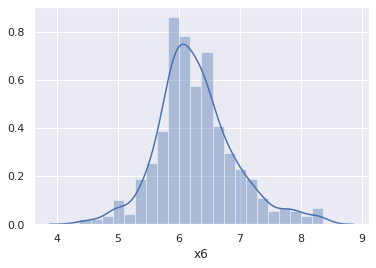

In [30]:
# 抽出した値の分布
sns.distplot(df2["x6"])

## 3. 外れ値除去 (全変数)
3σ法を全変数に適用

### モデルの精度の上げ方

- 外れ値は取り除く
- 外れ値を平均、中央地で補完する
- 主成分分析などを利用して、潜在変数に変換後、3σ法を適用する


In [31]:
cols = df.columns
cols

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'y'],
      dtype='object')

In [33]:
_df = df

mean = df.mean()
sigma = df.std()

for col in cols:
    # 3σ法の上限値/下限値の設定
    low = mean[col] - 3 * sigma[col]
    high = mean[col] + 3 * sigma[col]
    
    # 条件で絞り込み
    _df = _df[(_df[col] >= low) & (_df[col] <= high)]

In [34]:
# オリジナル
len(df)

506

In [35]:
# 3σ適用後
len(_df)

415

## 4. モデル構築

In [36]:
_df.head(3)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [49]:
# 学習用データと検証用データに分割
x = _df.drop("y", axis=1)
t = _df["y"]
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.4, random_state=1)

In [51]:
# 学習 (重回帰分析)
model = LinearRegression()
model.fit(x_train, t_train)

LinearRegression()

In [53]:
print(model.score(x_train, t_train))
print(model.score(x_test, t_test))

0.7972109224535133
0.6253776004329581


In [55]:
# 検証データとテストデータの予測精度に乖離がある -> 過学習(オーバーフィッティング)
# 過学習の回避方法: データのクレンジングなどが必要

## 5. スケーリングを考慮した重回帰分析

※ スケーリングを行うとパラメータ(w)がどの程度結果に影響しているのかがわかりやすくなる

In [80]:
# データのスケールが統一されていない
df2.head(3)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


In [81]:
from sklearn.preprocessing import StandardScaler

In [82]:
scaler = StandardScaler()

In [83]:
# scalerの学習(平均と標準偏差の算出)
scaler.fit(x_train)

StandardScaler()

In [84]:
# scaling(標準化)
x_train2 = scaler.transform(x_train)

In [85]:
# モデルの学習
model = LinearRegression().fit(x_train2, t_train)

In [86]:
# 検証(訓練データ)
model.score(x_train2, t_train)

0.7972109224535133

In [87]:
# scaling(標準化)
x_test2 = scaler.transform(x_test) # テストデータの標準化も訓練データの平均と標準偏差で行う

# 検証(検証データ)
model.score(x_test2, t_test)

0.6253776004329595

In [88]:
# 重みを確認
model.coef_

array([-1.95426423e-01,  2.11543329e-01,  5.08277354e-01,  2.22044605e-16,
       -1.21336016e+00,  3.91986658e+00, -3.69861217e-01, -1.85711554e+00,
        1.16625182e+00, -1.52855186e+00, -1.87256630e+00,  2.44427080e-01,
       -2.76100147e+00])

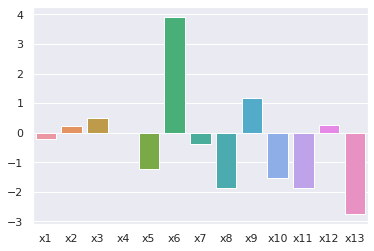

In [90]:
# x6, x13が特徴量として重要であることがわかる
# 逆に x4 は結果に影響を及ぼさない事がわかる。
sns.barplot(x=x.columns, y=model.coef_)